In [2]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from bioinfokit.visuz import cluster

from src.data.load_dataset import load_samples_01_to_06

# Outcome Analysis

### Aims of this analysis

We are trying to detect which gRNAs are outliers for a given gene, and which are not. To do so, we need to figure out how best to generate repair outcome profiles for each of the gRNAs, and then a method to identify outliers. Most outlier methods (Grubbs, Dixon's Q-test, Generalised ESD) rely on univariate data. 

The simpliest approach is to include all the outcomes, but the problem is sparsity. Some outcomes are very rare and may only occur for some gRNAs and not others by pure chance. This noise might make outlier detection difficult in a high-dimenionsal space (I think). So we need to narrow the number of dimensions and eliminate sparsity.

My previous approach was to try to define outcomes which occured more frequently than others for each biological replicate of each target site. These outlying outcomes would then form the "features"/dimensions/outcomes for which we would generate our outcome profiles. The problem with this approach is that these outcomes are the global outliers, and we throw away data that may be interesting when trying to identify local patterns among a small number of gRNAs. So we need a different approach.

Another idea was to try to use PCA. If we could capture the variation in the data using a small number of components, then we could have a small number of informative, dense dimensions which we could then use to calculate distance between gRNAs. Belows is a PCA analysis of the outcome data across all gRNAs for all the biological replicates across all the target sites


### Notes to self

PCA does not assume that the data is normally distributed. It assumes that the data is linearly related. See https://www.researchgate.net/post/Hello-everyone-Is-it-possible-to-do-PCA-analysis-if-data-is-not-normally-distributed.

### Load the data

First, we load the data. This data excludes any rows (outcomes) where the outcome constitutes less than .01 of a KO gRNAs repair outcome profile. This is to remove noise.

In [4]:
df = load_samples_01_to_06(min_mut_events=1000, min_frequency=0.01)
df.head(20)

loaded outcomes


/Users/colm/repos/MUSICian/src/data/load_dataset.py:73: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx[["fraction_per_barcode"]].sum(level="Barcode")


Normalised per Gene


fraction_per_barcode
Alias Gene          Barcode         outcome                                         
MB01  0610009B22Rik 0610009B22Rik-1 DELETION|-1|5||3bp                      0.004505
                                    DELETION|-4|7||4bp                      0.007743
                                    DELETION|0|1||1bp                       0.005385
                                    DELETION|0|3||2bp                       0.006370
                                    DELETION|0|6||0bp                       0.002112
                                    HDR|-34|1|ATTAAGGTACC|-1bp              0.019146
                                    INSERTION|1|1|A|-1bp                    0.004435
                                    WT|0|0||-1bp                            0.119063
                    0610009B22Rik-2 DELETION|-11|2||3bp                     0.002538
                                    DELETION|-1|5||3bp                      0.006049
                                    DELETION|-4|7||4bp                      0.008823
                                    DELETION|0|1||1bp                       0.006875
                                    DELETION|0|3||2bp                       0.005843
                                    DELETION|0|6||0bp                       0.002803
                                    HDR|-34|1|ATTAAGGTACC|-1bp              0.015138
                                    INSERTION|1|1|A|-1bp                    0.005075
                                    WT|0|0||-1bp                            0.115111
                    0610009B22Rik-3 DELETION|-11|2||3bp                     0.002770
                                    DELETION|-1|5||3bp                      0.007235
                                    DELETION|-2|2||2bp                      0.002061

In [5]:
df.loc[("MB01", "0610009B22Rik", "0610009B22Rik-3")]

,fraction_per_barcode
outcome,
DELETION|-11|2||3bp,0.002770
DELETION|-1|5||3bp,0.007235
DELETION|-2|2||2bp,0.002061
DELETION|-4|7||4bp,0.011150
DELETION|0|1||1bp,0.004968
DELETION|0|3||2bp,0.008494
DELETION|0|6||0bp,0.002129
HDR|-34|1|ATTAAGGTACC|-1bp,0.014745
INSERTION|1|1|A|-1bp,0.004373


In [6]:
print("This leaves {} rows".format(df.shape[0]))
print("This consists of {} unique outcomes per target site and replicate".format(df.groupby(["Alias", "outcome"]).size().shape[0]))

This leaves 4047504 rows
This consists of 26381 unique outcomes per target site and replicate


In [7]:
number_gRNA = df.index.get_level_values("Barcode").unique().shape[0]
number_gRNA

78311

In [8]:
number_gRNA * 0.001

78.311

In [9]:
number_gRNA_per_sample = df.groupby(["Alias", "Barcode"]).size().groupby(["Alias"]).size()
number_gRNA_per_sample

Alias
MB01    66813
MB02    68668
MB03    74666
MB04    77622
MB05    72822
MB06    71625
dtype: int64

Need to take only the common KO gRNA across all of the samples. If one sample is missing a gRNA, then that gRNA will be outlying for that particular gene. 

In [10]:
# TODO: take only the common gRNAs
common_barcodes = []
for alias in df.index.get_level_values("Alias").unique():
    common_barcodes.append(df.loc[alias].index.get_level_values("Barcode").to_list())

from functools import reduce
common_barcodes = reduce(np.intersect1d, common_barcodes)
np.unique(common_barcodes).shape

(63552,)

In [11]:
df2 = df.reset_index()
print(df2.shape[0])
df2 = df2[df2["Barcode"].isin(common_barcodes)]
print(df2.shape[0])
df2 = df2.set_index(["Alias", "Gene", "Barcode", "outcome"])
df2.groupby(["Alias", "Barcode"]).size().groupby(["Alias"]).size()



4047504
3534235


Alias
MB01    63552
MB02    63552
MB03    63552
MB04    63552
MB05    63552
MB06    63552
dtype: int64

In [12]:
number_unique_outcomes_per_sample = df.groupby(["Alias", "outcome"]).size().groupby(["Alias"]).size()
number_unique_outcomes_per_sample

Alias
MB01    3034
MB02    4577
MB03    4607
MB04    6255
MB05    3942
MB06    3966
dtype: int64

In [13]:
df.shape[0]/(number_gRNA * number_unique_outcomes_per_sample).sum()

0.001959175147002163

At this point, our matrix is very sparse. We note that many of these outcomes may only appear for a small number of KO gRNAs. That will leave the dataset very sparse. As we do not want to aggregate gRNAs together at this point, our alternatives are to try run PCA at this point, or try to reduce the number of considered outcomes.

One way we can reduce the number of considered outcomes is to apply another filter which excludes outcomes that do not appear in more than X% of all the barcodes. 

In [14]:
# defines the frequency at which a unique outcome must across all KO guide RNA within one biological replicate for one target sequence
# FREQUENCY_THRESHOLD = 0.001
FREQUENCY_THRESHOLD = 0.001

In [15]:
outcome_frequency_per_sample = df.groupby(["Alias", "outcome"]).size().div(number_gRNA_per_sample, level="Alias")
outcome_frequency_per_sample.head()

Alias  outcome              
MB01   DELETION|-10|-1||3bp     0.000374
       DELETION|-10|0||0bp      0.000374
       DELETION|-10|116||0bp    0.000015
       DELETION|-10|13||0bp     0.000045
       DELETION|-10|14||0bp     0.000120
dtype: float64

In [16]:
outcome_frequency_per_sample = outcome_frequency_per_sample[outcome_frequency_per_sample > FREQUENCY_THRESHOLD]
outcome_frequency_per_sample

Alias  outcome                    
MB01   DELETION|-10|2||1bp            0.029021
       DELETION|-10|5||3bp            0.051203
       DELETION|-10|6||2bp            0.017721
       DELETION|-11|2||3bp            0.242168
       DELETION|-12|0||1bp            0.001078
                                        ...   
MB06   HDR|-14|21|ATTAAGGTACC|-1bp    0.999986
       INSERTION|0|0|C|-1bp           0.005277
       INSERTION|0|0|T|-1bp           0.001019
       INSERTION|1|1|G|-1bp           1.000000
       WT|0|0||-1bp                   1.000000
Length: 391, dtype: float64

In [17]:
dfs = []

for sample in list(outcome_frequency_per_sample.index.get_level_values("Alias").unique()):
    outcomes_for_sample = list(outcome_frequency_per_sample[sample].index)
    print("Sample {} has {} unique outcomes".format(sample, len(outcomes_for_sample)))
    idx = pd.IndexSlice
    dfs.append(df.loc[idx[sample], :, :, outcomes_for_sample])

df_reduced = pd.concat(dfs)
df_reduced.head()

Sample MB01 has 54 unique outcomes
Sample MB02 has 67 unique outcomes
Sample MB03 has 62 unique outcomes
Sample MB04 has 85 unique outcomes
Sample MB05 has 61 unique outcomes
Sample MB06 has 62 unique outcomes


fraction_per_barcode
Alias Gene          Barcode         outcome                                 
MB01  0610009B22Rik 0610009B22Rik-1 DELETION|-1|5||3bp              0.004505
                                    DELETION|-4|7||4bp              0.007743
                                    DELETION|0|1||1bp               0.005385
                                    DELETION|0|3||2bp               0.006370
                                    DELETION|0|6||0bp               0.002112

In [18]:
df_reduced.shape

(3977959, 1)

In [19]:
reduced_number_unique_outcomes_per_sample = df_reduced.groupby(["Alias", "outcome"]).size().groupby(["Alias"]).size()
reduced_number_unique_outcomes_per_sample

Alias
MB01    54
MB02    67
MB03    62
MB04    85
MB05    61
MB06    62
dtype: int64

In [20]:
df_reduced.shape[0]/(number_gRNA * reduced_number_unique_outcomes_per_sample).sum()

0.12991544207254693

We have reduced the sparsity almost 80 fold, but it is still a very sparse dataset.

In [21]:
df_gRNA_profiles = df_reduced.reset_index().pivot(index="Barcode", columns=["Alias", "outcome"], values="fraction_per_barcode").fillna(0)
df_gRNA_profiles.head()

Alias                         MB01                                       \
outcome         DELETION|-1|5||3bp DELETION|-4|7||4bp DELETION|0|1||1bp   
Barcode                                                                   
0610009B22Rik-1           0.004505           0.007743          0.005385   
0610009B22Rik-2           0.006049           0.008823          0.006875   
0610009B22Rik-3           0.007235           0.011150          0.004968   
0610009B22Rik-4           0.006244           0.011918          0.004757   
0610009B22Rik-5           0.005013           0.010796          0.005517   

Alias                                                \
outcome         DELETION|0|3||2bp DELETION|0|6||0bp   
Barcode                                               
0610009B22Rik-1          0.006370          0.002112   
0610009B22Rik-2          0.005843          0.002803   
0610009B22Rik-3          0.008494          0.002129   
0610009B22Rik-4          0.009217          0.000000   
0610009B22Rik-5          0.007267          0.002818   

Alias                                                                         \
outcome         HDR|-34|1|ATTAAGGTACC|-1bp INSERTION|1|1|A|-1bp WT|0|0||-1bp   
Barcode                                                                        
0610009B22Rik-1                   0.019146             0.004435     0.119063   
0610009B22Rik-2                   0.015138             0.005075     0.115111   
0610009B22Rik-3                   0.014745             0.004373     0.108823   
0610009B22Rik-4                   0.017567             0.006938     0.109737   
0610009B22Rik-5                   0.012606             0.006822     0.125433   

Alias                                                   ...  \
outcome         DELETION|-11|2||3bp DELETION|-2|2||2bp  ...   
Barcode                                                 ...   
0610009B22Rik-1            0.000000           0.000000  ...   
0610009B22Rik-2            0.002538           0.000000  ...   
0610009B22Rik-3            0.002770           0.002061  ...   
0610009B22Rik-4            0.000000           0.002205  ...   
0610009B22Rik-5            0.000000           0.000000  ...   

Alias                          MB06                                          \
outcome         DELETION|-10|0||3bp DELETION|0|209||3bp DELETION|-7|10||2bp   
Barcode                                                                       
0610009B22Rik-1                 0.0                 0.0                 0.0   
0610009B22Rik-2                 0.0                 0.0                 0.0   
0610009B22Rik-3                 0.0                 0.0                 0.0   
0610009B22Rik-4                 0.0                 0.0                 0.0   
0610009B22Rik-5                 0.0                 0.0                 0.0   

Alias                                                                     \
outcome         DELETION|-2|2||0bp DELETION|-5|12||1bp DELETION|1|6||0bp   
Barcode                                                                    
0610009B22Rik-1                0.0                 0.0               0.0   
0610009B22Rik-2                0.0                 0.0               0.0   
0610009B22Rik-3                0.0                 0.0               0.0   
0610009B22Rik-4                0.0                 0.0               0.0   
0610009B22Rik-5                0.0                 0.0               0.0   

Alias                                                                        \
outcome         DELETION|0|215||2bp DELETION|-4|12||1bp DELETION|1|132||4bp   
Barcode                                                                       
0610009B22Rik-1                 0.0                 0.0                 0.0   
0610009B22Rik-2                 0.0                 0.0                 0.0   
0610009B22Rik-3                 0.0                 0.0                 0.0   
0610009B22Rik-4                 0.0                 0.0                 0.0   
0610009B22Rik-5  

In [22]:
df_gRNA_profiles.shape

(78311, 391)

Lets get an idea of the sparsity of the columns

<AxesSubplot:>

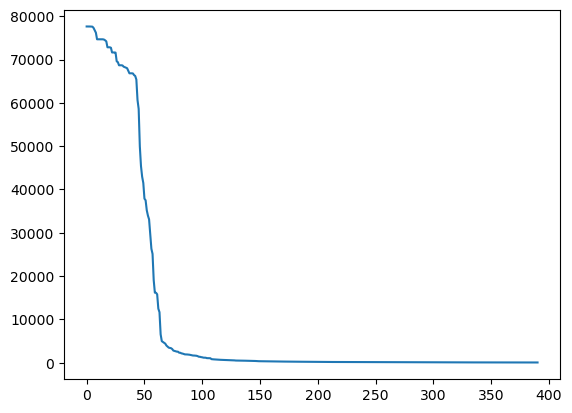

In [23]:
sparsity_sorted = ((df_gRNA_profiles > 0).sum()).sort_values(ascending=False)

sns.lineplot(y = sparsity_sorted, x= np.arange(len(sparsity_sorted)))

In [24]:
outcome_corr = df_gRNA_profiles.corr()
outcome_corr

Alias                                    MB01                     \
outcome                    DELETION|-1|5||3bp DELETION|-4|7||4bp   
Alias outcome                                                      
MB01  DELETION|-1|5||3bp             1.000000           0.699658   
      DELETION|-4|7||4bp             0.699658           1.000000   
      DELETION|0|1||1bp              0.619024           0.703265   
      DELETION|0|3||2bp              0.674710           0.762650   
      DELETION|0|6||0bp              0.389351           0.440757   
...                                       ...                ...   
MB06  DELETION|1|6||0bp             -0.002817          -0.014235   
      DELETION|0|215||2bp           -0.010155          -0.012167   
      DELETION|-4|12||1bp           -0.016551          -0.022280   
      DELETION|1|132||4bp           -0.019867          -0.019978   
      DELETION|-10|12||1bp          -0.012245          -0.016216   

Alias                                                           \
outcome                    DELETION|0|1||1bp DELETION|0|3||2bp   
Alias outcome                                                    
MB01  DELETION|-1|5||3bp            0.619024          0.674710   
      DELETION|-4|7||4bp            0.703265          0.762650   
      DELETION|0|1||1bp             1.000000          0.682762   
      DELETION|0|3||2bp             0.682762          1.000000   
      DELETION|0|6||0bp             0.389377          0.426734   
...                                      ...               ...   
MB06  DELETION|1|6||0bp            -0.010140         -0.012947   
      DELETION|0|215||2bp          -0.009830         -0.012891   
      DELETION|-4|12||1bp          -0.019569         -0.024158   
      DELETION|1|132||4bp          -0.019955         -0.021548   
      DELETION|-10|12||1bp         -0.015734         -0.015026   

Alias                                                                    \
outcome                    DELETION|0|6||0bp HDR|-34|1|ATTAAGGTACC|-1bp   
Alias outcome                                                             
MB01  DELETION|-1|5||3bp            0.389351                   0.665587   
      DELETION|-4|7||4bp            0.440757                   0.767045   
      DELETION|0|1||1bp             0.389377                   0.687489   
      DELETION|0|3||2bp             0.426734                   0.727663   
      DELETION|0|6||0bp             1.000000                   0.419032   
...                                      ...                        ...   
MB06  DELETION|1|6||0bp            -0.007355                  -0.013140   
      DELETION|0|215||2bp          -0.005004                  -0.011093   
      DELETION|-4|12||1bp          -0.010232                  -0.023873   
      DELETION|1|132||4bp          -0.013867                  -0.019005   
      DELETION|-10|12||1bp         -0.008943                  -0.014969   

Alias                                                         \
outcome                    INSERTION|1|1|A|-1bp WT|0|0||-1bp   
Alias outcome                                                  
MB01  DELETION|-1|5||3bp               0.630823     0.676578   
      DELETION|-4|7||4bp               0.720648     0.768493   
      DELETION|0|1||1bp                0.662343     0.713534   
      DELETION|0|3||2bp                0.700147     0.753228   
      DELETION|0|6||0bp                0.397633     0.392528   
...                                         ...          ...   
MB06  DELETION|1|6||0bp               -0.012908    -0.018026   
      DELETION|0|215||2bp             -0.014649    -0.017524   
      DELETION|-4|12||1bp             -0.022299    -0.028369   
      DELETION|1|132||4bp             -0.022399    -0.025846   
      DELETION|-10|12||1bp            -0.013354    -0.019514   

Alias                                                              ...  \
outcome                    DELETION|-11|2||3bp DELETION|-2|2||2bp  ...   
Alias outcome             

From this heatmap, we note two things:
 - There is a small cluster of outcomes towards the top-left corner of the heatmap that are reasonably highly correlated. These are groups of outcomes that cluster together.
 - The rest of the data does not seem to correlate at all. 

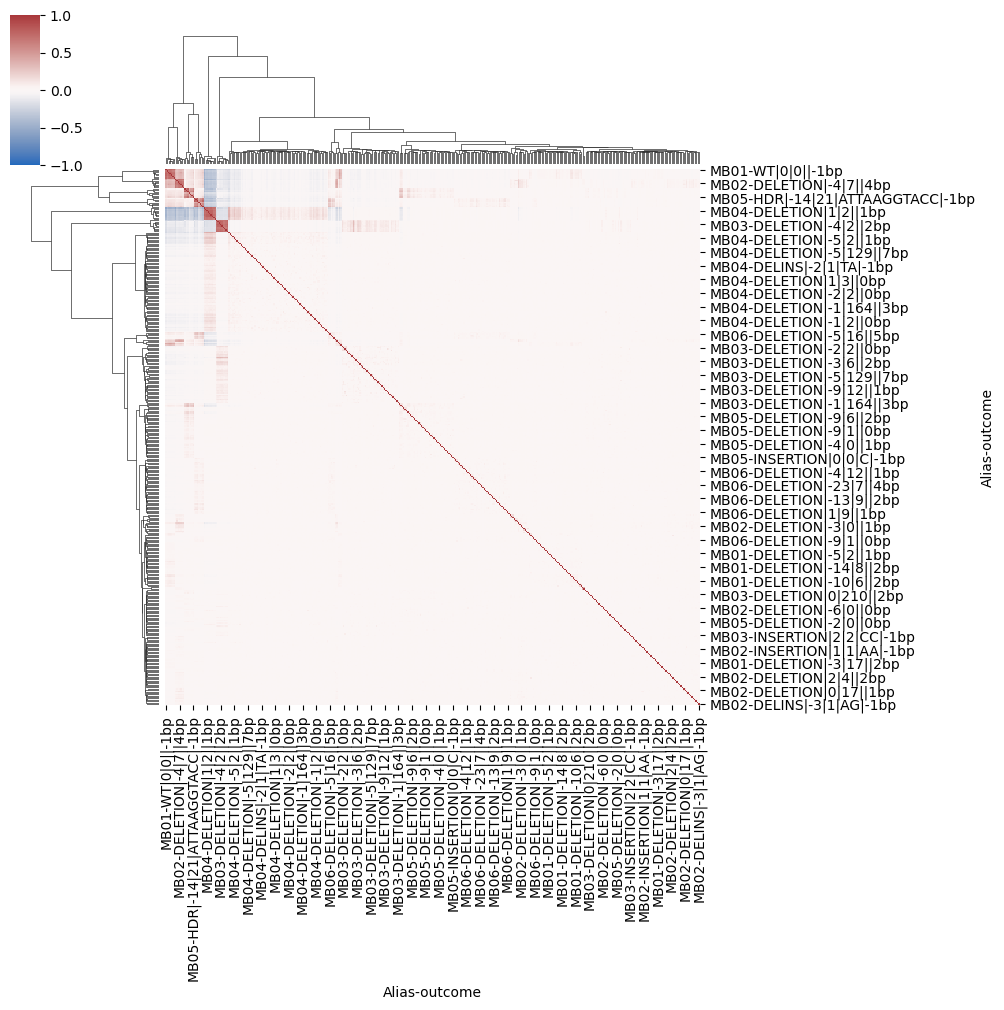

In [25]:
from scipy.cluster import hierarchy as hc
import sys

z = hc.linkage(outcome_corr, method="ward")
sns.clustermap(outcome_corr, cmap="vlag", vmax=1, vmin=-1, center=0, row_linkage=z, col_linkage=z, cbar_pos=(0, 0.85, .03, .15))

7


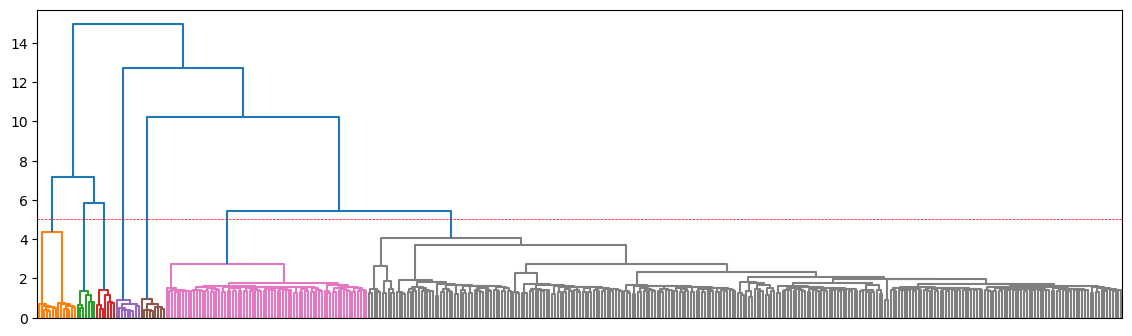

In [26]:
distance_threshold = 5.0

plt.figure(figsize=(14, 4))
dn = hierarchy.dendrogram(z, no_labels=True, color_threshold=distance_threshold)
plt.axhline(distance_threshold, ls="--", c="r", lw=.5)

from scipy.cluster.hierarchy import fcluster

clusters = fcluster(z, distance_threshold, criterion="distance")
num_clusters = np.unique(clusters).shape[0]
print(num_clusters)

In [27]:
cluster_membership = []

for k in range(1, num_clusters-1):
    cluster_membership.append(outcome_corr.index.to_numpy()[np.where(clusters == k)])
    print(cluster_membership[-1])
    

[('MB01', 'DELETION|-1|5||3bp') ('MB01', 'DELETION|-4|7||4bp')
 ('MB01', 'DELETION|0|1||1bp') ('MB01', 'DELETION|0|3||2bp')
 ('MB01', 'HDR|-34|1|ATTAAGGTACC|-1bp') ('MB01', 'INSERTION|1|1|A|-1bp')
 ('MB01', 'WT|0|0||-1bp') ('MB02', 'DELETION|-1|5||3bp')
 ('MB02', 'DELETION|-4|7||4bp') ('MB02', 'DELETION|0|1||1bp')
 ('MB02', 'DELETION|0|3||2bp') ('MB02', 'HDR|-34|1|ATTAAGGTACC|-1bp')
 ('MB02', 'INSERTION|1|1|A|-1bp') ('MB02', 'WT|0|0||-1bp')]
[('MB05', 'DELETION|-3|2||1bp') ('MB05', 'DELETION|-6|3||1bp')
 ('MB05', 'DELETION|-8|3||2bp') ('MB05', 'DELETION|1|3||2bp')
 ('MB05', 'HDR|-14|21|ATTAAGGTACC|-1bp') ('MB05', 'INSERTION|1|1|G|-1bp')
 ('MB05', 'WT|0|0||-1bp')]
[('MB06', 'DELETION|-3|2||1bp') ('MB06', 'DELETION|-6|3||1bp')
 ('MB06', 'DELETION|-8|3||2bp') ('MB06', 'DELETION|1|3||2bp')
 ('MB06', 'HDR|-14|21|ATTAAGGTACC|-1bp') ('MB06', 'INSERTION|1|1|G|-1bp')
 ('MB06', 'WT|0|0||-1bp')]
[('MB04', 'DELETION|-4|2||2bp') ('MB04', 'DELETION|-5|5||3bp')
 ('MB04', 'DELETION|0|2||1bp') ('MB04',

<AxesSubplot:ylabel='Alias,outcome'>

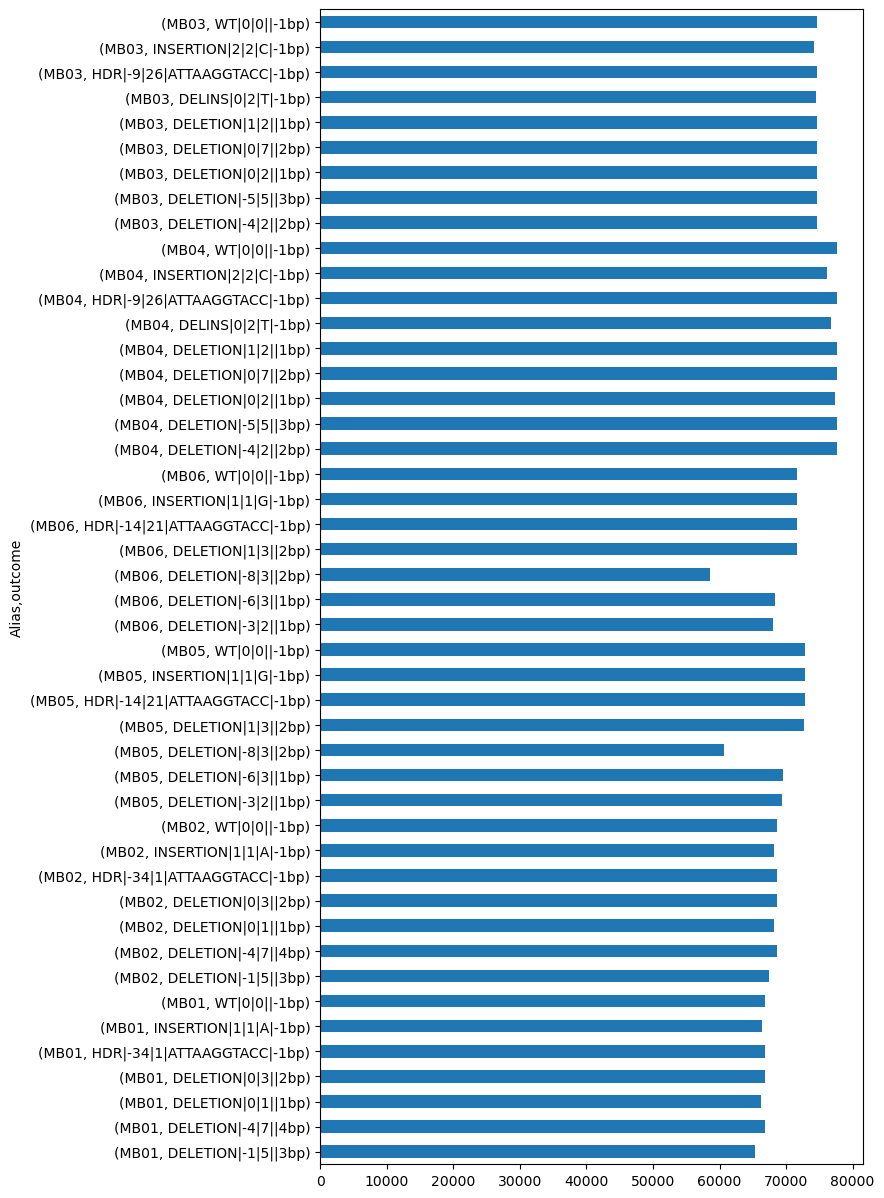

In [28]:
outcomes_to_investigate = np.concatenate(cluster_membership)
plt.figure(figsize=(7, 15))
df.groupby(["Alias", "outcome"]).size().loc[outcomes_to_investigate].plot.barh()


### Principal Component Analysis

In [29]:
from sklearn.preprocessing import StandardScaler

x = df_gRNA_profiles

x = StandardScaler().fit_transform(x)
x[:5,:5]

array([[ 0.20697107, -0.23025717,  0.43162164,  0.01263637,  0.17570246],
       [ 0.87022988,  0.01035126,  1.05375947, -0.14628686,  0.57832659],
       [ 1.3795592 ,  0.52878171,  0.2578129 ,  0.65240065,  0.18595594],
       [ 0.95381734,  0.69975788,  0.16966894,  0.87008706, -1.05365857],
       [ 0.42501529,  0.44995946,  0.48672436,  0.28267176,  0.58674144]])

In [30]:
from sklearn.decomposition import PCA

pca = PCA()
pca_out = pca.fit(x)
principle_components = pca_out.transform(x)
components_names = ["PC" + str(i+1) for i in range(principle_components.shape[1])]
pca_df = pd.DataFrame(principle_components, columns=components_names)
pca_df.shape

(78311, 391)

In [31]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC382,PC383,PC384,PC385,PC386,PC387,PC388,PC389,PC390,PC391
0,-1.391825,-0.498292,-0.159126,0.163114,0.033740,-0.370872,-1.236570,0.192496,0.006851,-0.154437,...,0.167115,0.569351,0.009521,0.099650,0.243593,-0.155778,0.176916,-0.320139,0.257044,-0.004938
1,-1.560662,-0.810666,-0.315630,-1.187695,0.048287,0.089707,0.170803,-0.012519,-0.015863,0.065655,...,-0.162769,0.442557,0.136941,-0.028240,-0.355422,0.105482,0.090263,-0.351153,0.447685,-0.012657
2,-1.458970,-0.978256,-0.250638,-1.065412,-0.828583,-0.128410,-0.154936,-0.014781,0.003527,-0.071331,...,-0.234792,0.331831,0.221778,-0.240322,-0.300357,0.549411,0.272979,-0.308978,0.060703,0.015021
3,-1.840496,-0.049133,-0.045561,-0.455935,-0.858452,0.414415,-1.550498,0.071793,0.094928,0.067378,...,0.146495,-0.142287,-0.252913,0.002129,0.077197,0.337523,-0.057396,0.002836,-0.002619,-0.006360
4,-1.804574,-0.030954,0.256510,-0.890945,-0.650424,-0.058630,-1.442194,0.032842,0.074638,0.025523,...,-0.308272,0.024648,0.517279,-0.109689,-0.083291,0.131575,-0.260348,-0.320086,0.517374,-0.004180


0.1146642070495317

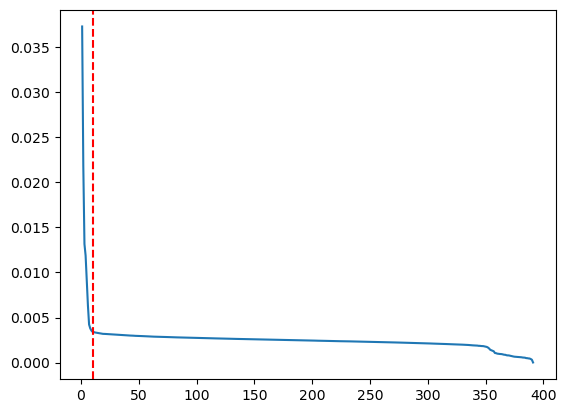

In [32]:
# scree plot

MANUALLY_SELECTED_THRESHOLD = 10
sns.lineplot(y=pca_out.explained_variance_ratio_, x=np.arange(pca_out.n_components_) + 1)
plt.axvline(MANUALLY_SELECTED_THRESHOLD, ls="--", color="red")
np.sum(pca_out.explained_variance_ratio_[:MANUALLY_SELECTED_THRESHOLD])

A lot of the variances in this plot are very similar. This means that the PCs are very unstable. Furthermore, it takes many, many PCs to explain the variance in the data. Need to think of another way to approach this.

https://bioturing.medium.com/how-to-read-pca-biplots-and-scree-plots-186246aae063

There are two alternatives to choosing the number of components to select:
- Kaiser rule: pick PCs with eignvalues of at least 1
- Proportion of variance plot: the selected PCs should describe at least 80% of the variance

In [33]:
kaisers_rule = sum(pca_out.explained_variance_ > 1)
kaisers_rule

157

225


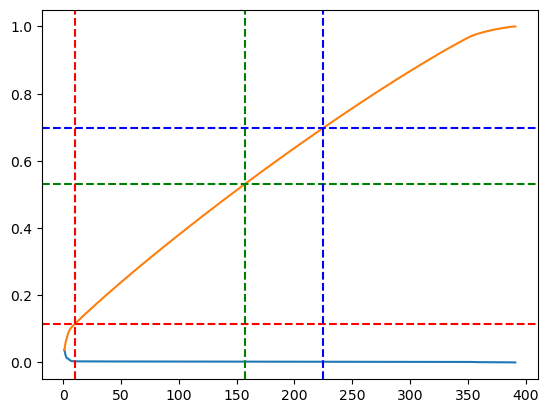

In [34]:
VARIANCE_TO_EXPLAIN = .7

var_cumsum = np.cumsum(pca_out.explained_variance_ratio_)
variance_explained_by_num_pcs = sum(var_cumsum < VARIANCE_TO_EXPLAIN)
print(variance_explained_by_num_pcs)

sns.lineplot(y=pca_out.explained_variance_ratio_, x=np.arange(pca_out.n_components_) + 1)
sns.lineplot(y=var_cumsum, x=np.arange(pca_out.n_components_) + 1)

plt.axvline(MANUALLY_SELECTED_THRESHOLD, ls="--", color="red")
plt.axhline(var_cumsum[MANUALLY_SELECTED_THRESHOLD-1], ls="--", color="red")

plt.axvline(kaisers_rule, ls="--", color="green")
plt.axhline(var_cumsum[kaisers_rule-1], ls="--", color="green")

plt.axvline(variance_explained_by_num_pcs, ls="--", color="blue")
plt.axhline(var_cumsum[variance_explained_by_num_pcs-1], ls="--", color="blue")

Comparing each of these methods, we can only explain a very low percentage of the variance in the data with a few components. Maybe PCA is not suitable to explain this data OR we need to deal with the sparsity. We can take a look at the loadings plot to see which features belong to which PCs

<AxesSubplot:ylabel='variable'>

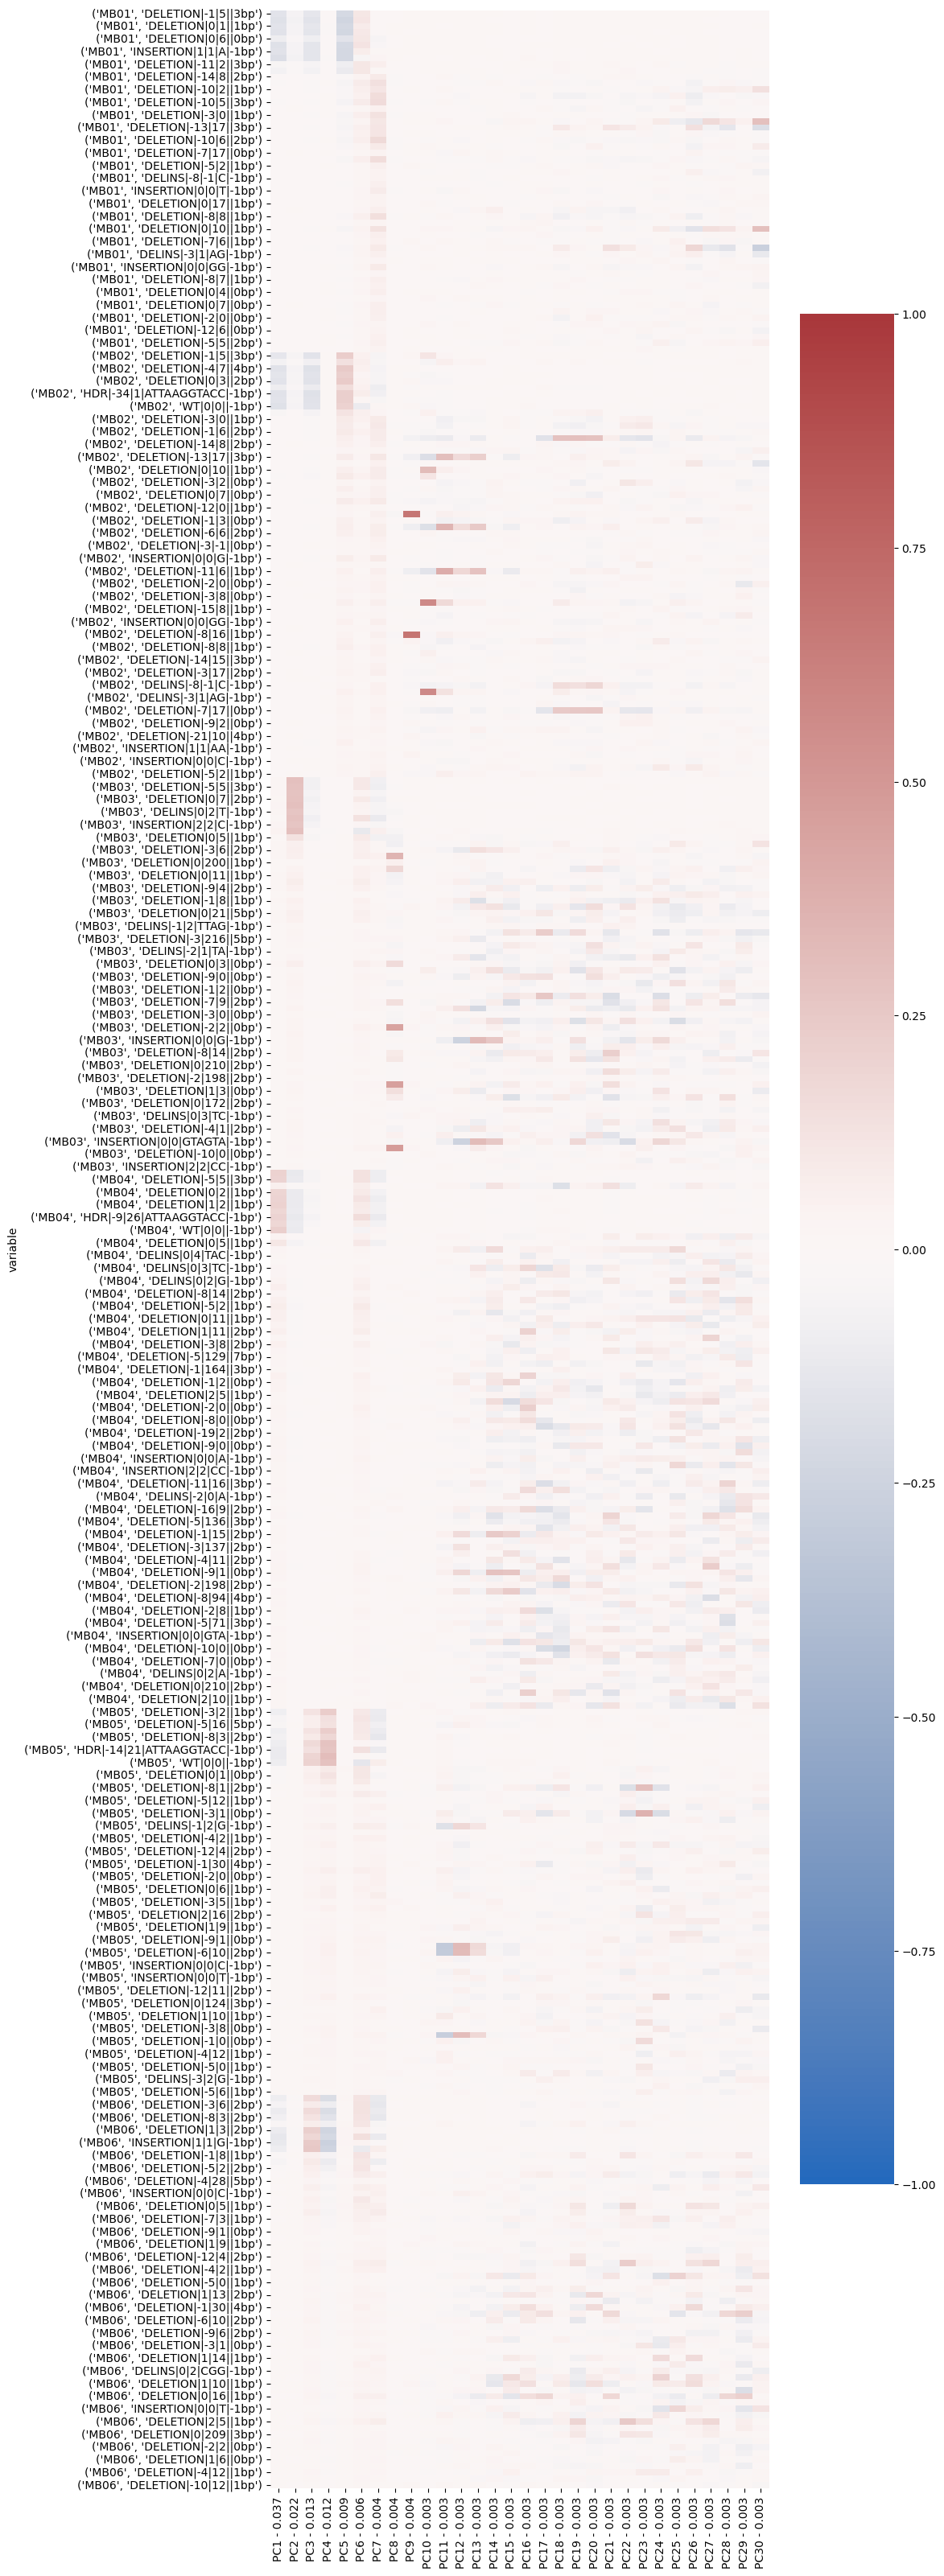

In [35]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i)+" - {:.3f}".format(pca_out.explained_variance_ratio_[i-1]) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_gRNA_profiles.columns.values
loadings_df = loadings_df.set_index('variable')

plt.figure(figsize=(10, 40))
sns.heatmap(loadings_df.iloc[:,:30], center=0, vmin=-1, vmax=1, cmap="vlag")


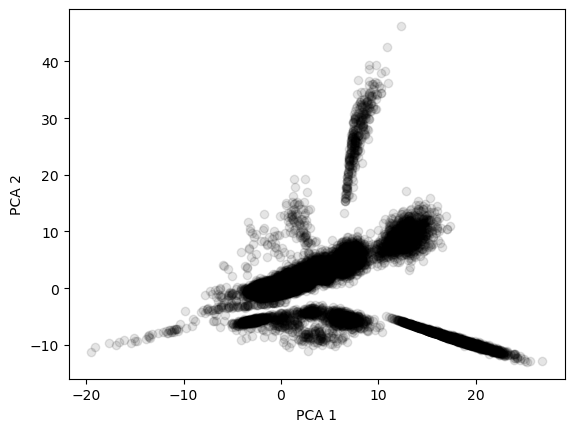

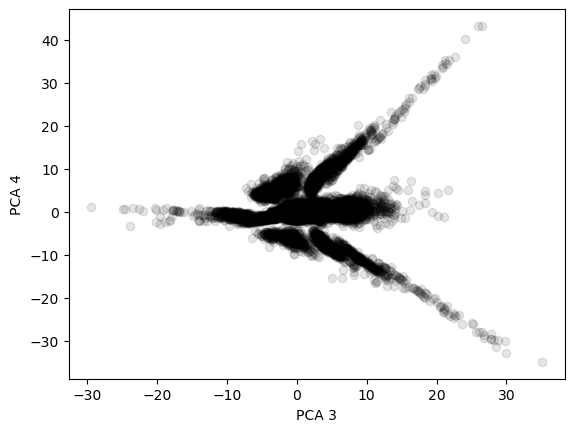

In [36]:
plt.scatter(principle_components[:,0], principle_components[:,1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

plt.scatter(principle_components[:,2], principle_components[:,3], alpha=.1, color='black')
plt.xlabel('PCA 3')
plt.ylabel('PCA 4')
plt.show()

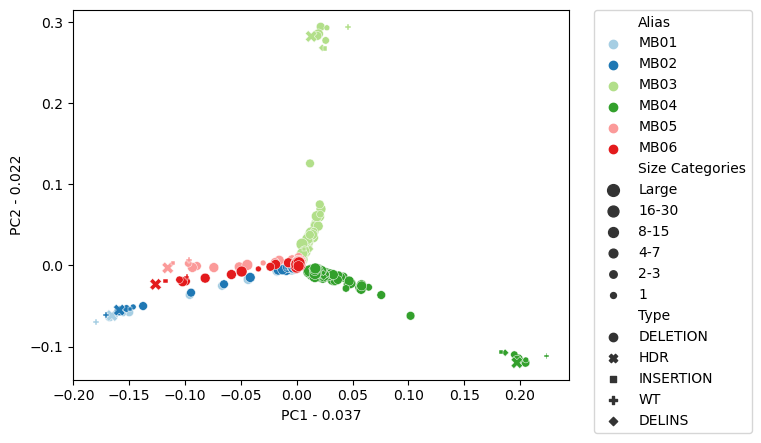

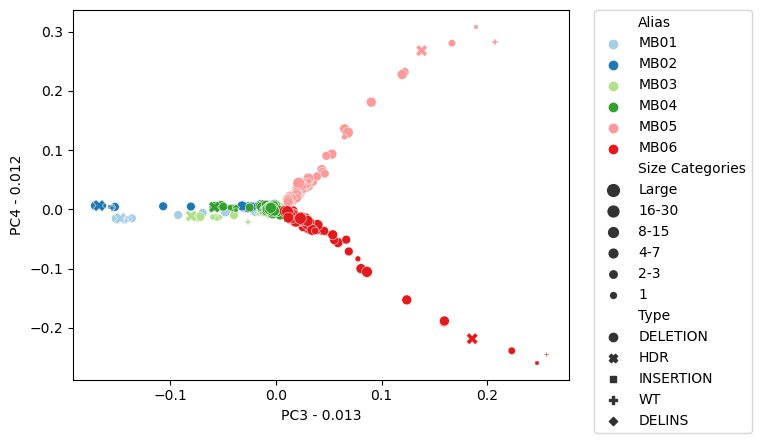

In [37]:
# TODO: Plot loading plots of features vs PC1 and PC2
# TODO: Label outlying points in plot to identify whats in these clusters. Use shapes to identify samples, use colour gradient to identify size of indel. Think of some way to represent insertion vs deletion vs WT. Maybe need two plots. 

loadings_plt_df = pd.concat([loadings_df, 
    loadings_df.index.to_series().apply(lambda x: x[0]).to_frame(name="Alias"),
    loadings_df.index.to_series().apply(lambda x: x[1]).str.split("|", expand=True).rename(columns={0: "Type", 1: "delRelativeStart", 2: "delRelativeEnd", 3: "misc", 4: "homologyLength"})], axis=1)
loadings_plt_df[["delRelativeStart", "delRelativeEnd"]] = loadings_plt_df[["delRelativeStart", "delRelativeEnd"]].astype(int)
loadings_plt_df["size"] = loadings_plt_df["delRelativeEnd"] - loadings_plt_df["delRelativeStart"]


def categorise_sizes(size):
    if size == 0: return "1"
    if size == 1: return "1"
    if size <=3: return "2-3"
    if size <=7: return "4-7"
    if size <= 15: return "8-15"
    if size <= 30: return "16-30"
    return "Large"

size_order = ["1", "2-3", "4-7", "8-15", "16-30", "Large"]
loadings_plt_df["Size Categories"] = loadings_plt_df["size"].apply(lambda x: categorise_sizes(x))

loadings_plt_df.head()


# https://www.reneshbedre.com/blog/principal-component-analysis.html#principal-component-pc-retention
sns.scatterplot(data=loadings_plt_df, x=loadings_df.columns[0], y=loadings_df.columns[1], hue="Alias", palette="Paired", style="Type", size="Size Categories", size_order=reversed(size_order))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



sns.scatterplot(data=loadings_plt_df, x=loadings_df.columns[2], y=loadings_df.columns[3], hue="Alias", palette="Paired", style="Type", size="Size Categories", size_order=reversed(size_order))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
# TODO: Plot Biplots, if possible. 

There are a number of explanations for why PCA behaves like it does above.

1. Most of the columns are noise. This would mean that the PCs struggle to distinguish themselves in any meaningful way. We could try stricter filters to reduce the level of noise in the data.
2. The columns are not noise, but the sparsity is introducing a problem for PCA. Can take a look at this post: https://stats.stackexchange.com/questions/190852/what-is-effect-on-pca-of-having-too-many-zeros-in-the-data
3. The data is highly non-linear and PCA is not going to be meaningful here. Consider doing UMAP.

### Conclusions

PCA is not an effective method of reducing the dimensionality of this dataset. To explain most of the variance, we need to include most of the features. For our outlier analysis, we need to think of a simple solution that captures the local variations between sgRNAs.


One algorithm I propose is the following.

1. - Select all barcodes for a given gene
2. - Select all outcomes common across those barcodes.
3. - Generate the normalised outcomes for each gRNA
4. - Calculate the geometric median (more robust than calculating the centroid, which could be prone to masking as averages are more affected by outliers)
5. - Calculate distance to the geometric median.
6. - Perform univariate Dixon's Q-test to determine if the profiles is an outlying point.

Another options is Mahalanobis Distance or Leverage (see wiki or slides). The issue I'm worried about is "masking" with such a low number of points, as some measures are not robust to outlying data.